[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...



Model: MultinomialNB
Accuracy: 0.87
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.56      0.83      0.67        18
           comp.graphics       0.94      0.83      0.88        18
 comp.os.ms-windows.misc       0.90      0.86      0.88        22
comp.sys.ibm.pc.hardware       0.87      0.80      0.83        25
   comp.sys.mac.hardware       0.91      1.00      0.95        21
          comp.windows.x       0.92      0.92      0.92        25
            misc.forsale       0.75      0.83      0.79        18
               rec.autos       0.86      1.00      0.92        18
         rec.motorcycles       1.00      0.94      0.97        16
      rec.sport.baseball       0.90      1.00      0.95        18
        rec.sport.hockey       1.00      1.00      1.00        15
               sci.crypt       0.95      1.00      0.97        19
         sci.electronics       0.71      0.75      0.73        16
              

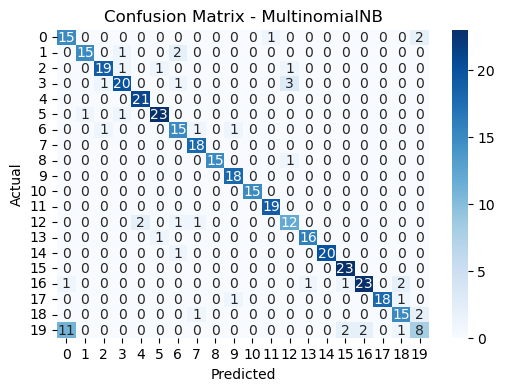


Model: BernoulliNB
Accuracy: 0.7375
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.50      0.67      0.57        18
           comp.graphics       0.73      0.44      0.55        18
 comp.os.ms-windows.misc       0.63      0.77      0.69        22
comp.sys.ibm.pc.hardware       0.87      0.80      0.83        25
   comp.sys.mac.hardware       0.83      0.95      0.89        21
          comp.windows.x       0.89      0.68      0.77        25
            misc.forsale       0.29      0.89      0.44        18
               rec.autos       0.77      0.94      0.85        18
         rec.motorcycles       0.82      0.88      0.85        16
      rec.sport.baseball       0.95      1.00      0.97        18
        rec.sport.hockey       1.00      1.00      1.00        15
               sci.crypt       0.94      0.89      0.92        19
         sci.electronics       0.52      0.75      0.62        16
              

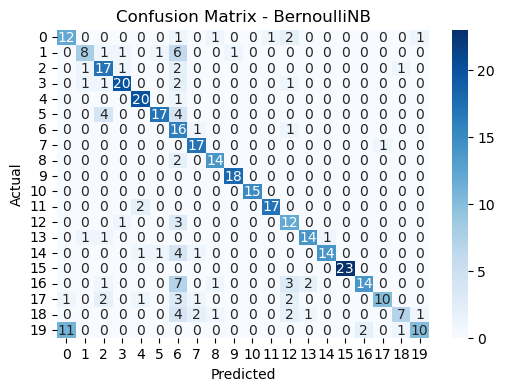


Model: GaussianNB
Accuracy: 0.6075
Classification Report:
                           precision    recall  f1-score   support

             alt.atheism       0.53      0.44      0.48        18
           comp.graphics       0.34      0.78      0.47        18
 comp.os.ms-windows.misc       0.70      0.64      0.67        22
comp.sys.ibm.pc.hardware       0.76      0.52      0.62        25
   comp.sys.mac.hardware       0.60      0.43      0.50        21
          comp.windows.x       0.70      0.56      0.62        25
            misc.forsale       0.67      0.44      0.53        18
               rec.autos       0.65      0.61      0.63        18
         rec.motorcycles       0.75      0.56      0.64        16
      rec.sport.baseball       1.00      0.72      0.84        18
        rec.sport.hockey       0.78      0.93      0.85        15
               sci.crypt       0.76      0.68      0.72        19
         sci.electronics       0.30      0.19      0.23        16
               

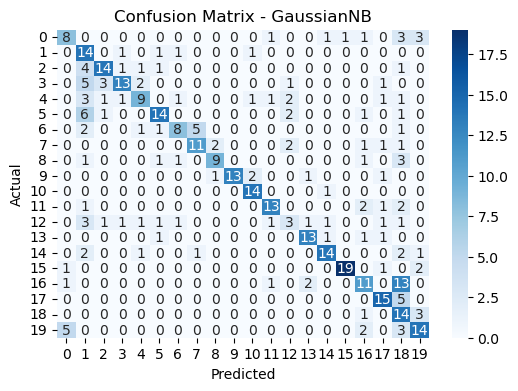

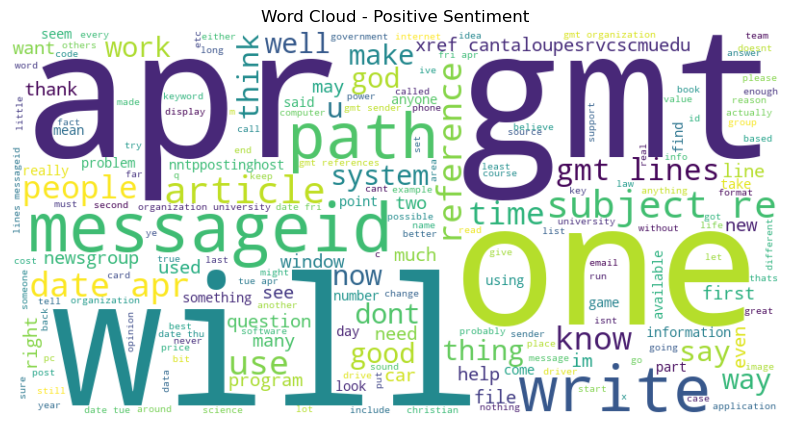

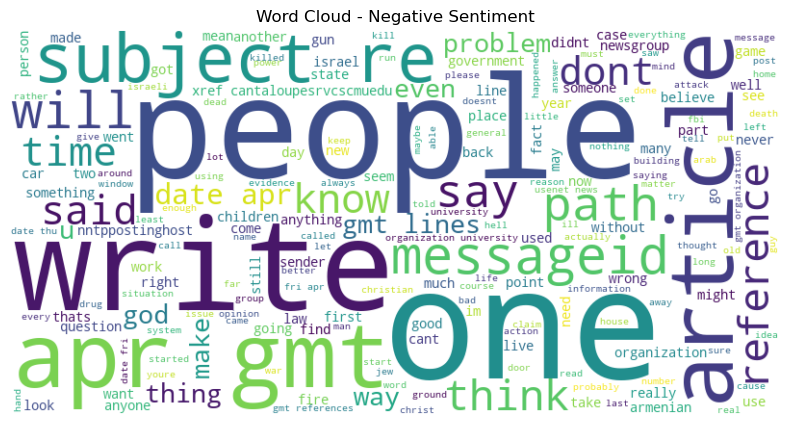

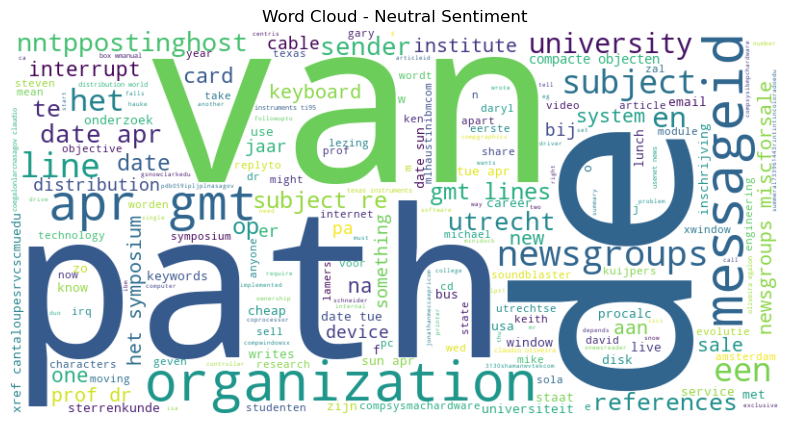

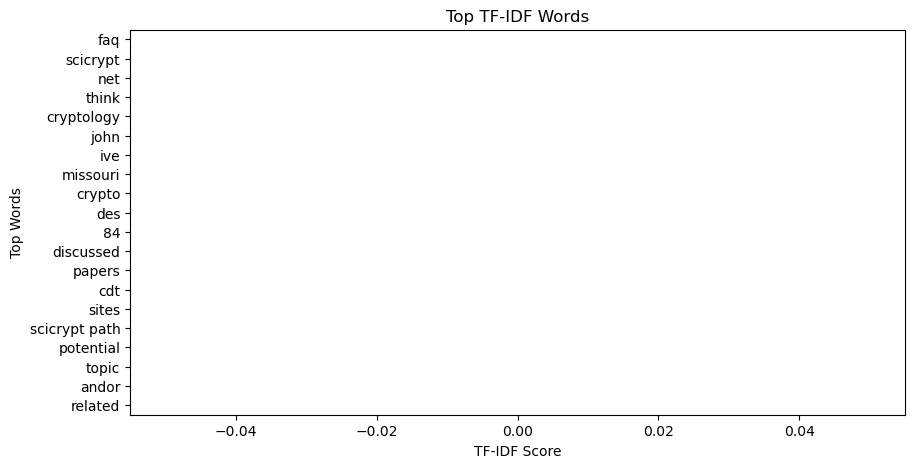

In [1]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Load dataset
df = pd.read_csv(r"C:\Users\Owner\OneDrive\Desktop\SVM\NLP\blogs.csv")

# Data Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub("\s+", " ", text).strip()  # Remove extra whitespace
    return text

df["Cleaned_Data"] = df["Data"].apply(clean_text)

# TF-IDF Vectorization with N-grams
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
X = vectorizer.fit_transform(df["Cleaned_Data"])
y = df["Labels"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and Evaluate Different Naïve Bayes Models
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB()
}

for name, model in models.items():
    if name == "GaussianNB":
        model.fit(X_train.toarray(), y_train)
        y_pred = model.predict(X_test.toarray())
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Sentiment Analysis using VADER
def get_sentiment_vader(text):
    sentiment_score = sia.polarity_scores(text)["compound"]
    if sentiment_score > 0:
        return "Positive"
    elif sentiment_score < 0:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment_VADER"] = df["Cleaned_Data"].apply(get_sentiment_vader)

# Word Cloud Visualization
def generate_wordcloud(data, title):
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate Word Clouds for each Sentiment
for sentiment in ["Positive", "Negative", "Neutral"]:
    generate_wordcloud(df[df["Sentiment_VADER"] == sentiment]["Cleaned_Data"], f"Word Cloud - {sentiment} Sentiment")

# Feature Importance (Top TF-IDF Words)
def plot_top_tfidf_words(vectorizer, top_n=20):
    feature_array = np.array(vectorizer.get_feature_names_out())
    tfidf_sorting = np.argsort(X_train.toarray()).flatten()[::-1]
    top_words = feature_array[tfidf_sorting][:top_n]
    top_values = X_train.toarray().flatten()[tfidf_sorting][:top_n]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_values, y=top_words, palette='viridis')
    plt.xlabel("TF-IDF Score")
    plt.ylabel("Top Words")
    plt.title("Top TF-IDF Words")
    plt.show()

plot_top_tfidf_words(vectorizer)
